# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [6]:
!hdfs dfs -copyFromLocal /workspace/data/MovieLens/data .

In [7]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-08 14:22 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-08 14:22 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-08 14:22 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-08 14:22 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-08 14:22 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-08 14:22 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-08 14:22 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-08 14:22 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-08 14:22 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [13]:
!hdfs dfs -cat data/ml-25m/ml-25m-README.htm


<!-- saved from url=(0064)http://files.grouplens.org/datasets/movielens/ml-25m-README.html -->
<html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"></head><body><h1>Summary</h1>

<p>This dataset (ml-25m) describes 5-star rating and free-text tagging activity from <a href="http://movielens.org/">MovieLens</a>, a movie recommendation service. It contains 25000095 ratings and 1093360 tag applications across 62423 movies. These data were created by 162541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019.</p>

<p>Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.</p>

<p>The data are contained in the files <code>genome-scores.csv</code>, <code>genome-tags.csv</code>, <code>links.csv</code>, <code>movies.csv</code>, <code>ratings.csv</code> and <code>tags.csv<

In [8]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [9]:
ratings = sc.textFile(RATINGS_PATH)

In [14]:
%%time
ratings.take(5)

CPU times: user 3.53 ms, sys: 1.17 ms, total: 4.7 ms
Wall time: 1.15 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [15]:
ratings.getNumPartitions()

5

In [16]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [17]:
ratings.count()

25000095

Количество пользователей

In [18]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 24.7 ms, sys: 48 µs, total: 24.8 ms
Wall time: 34.9 s


162541

Сохраним датасет в память

In [19]:
ratings = ratings.persist()

In [23]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 26.3 ms, sys: 4.79 ms, total: 31.1 ms
Wall time: 43.7 s


162541

Количество фильмов

In [26]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 8.19 ms, sys: 2.36 ms, total: 10.6 ms
Wall time: 18.6 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [27]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [28]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (193964, (5.0, ['193964', 'The Jade Pendant (2017)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (120303, (5.0, ['120303', "Girls' Club (1936)"])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (116243, (5.0, ['116243', 'Convicted (1931)'])),
 (83161, (5.0, ['83161', 'Deadly Delicious (Shuang Shi Ji) (2008)'])),
 (165285, (5.0, ['165285', 'Homeless for the Holidays (2009)'])),
 (165775, (5.0, ['165775', 'Four Mothers (1941)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [29]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [30]:
!hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-08 14:39 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59139 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112222 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131258 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114186 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133841 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117681 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143063 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132134 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167794 2021-02-08 14:39 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [31]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [32]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [33]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

In [36]:
tags_count[:5]

[('sci-fi', 8330),
 ('atmospheric', 6516),
 ('action', 5907),
 ('comedy', 5702),
 ('surreal', 5326)]

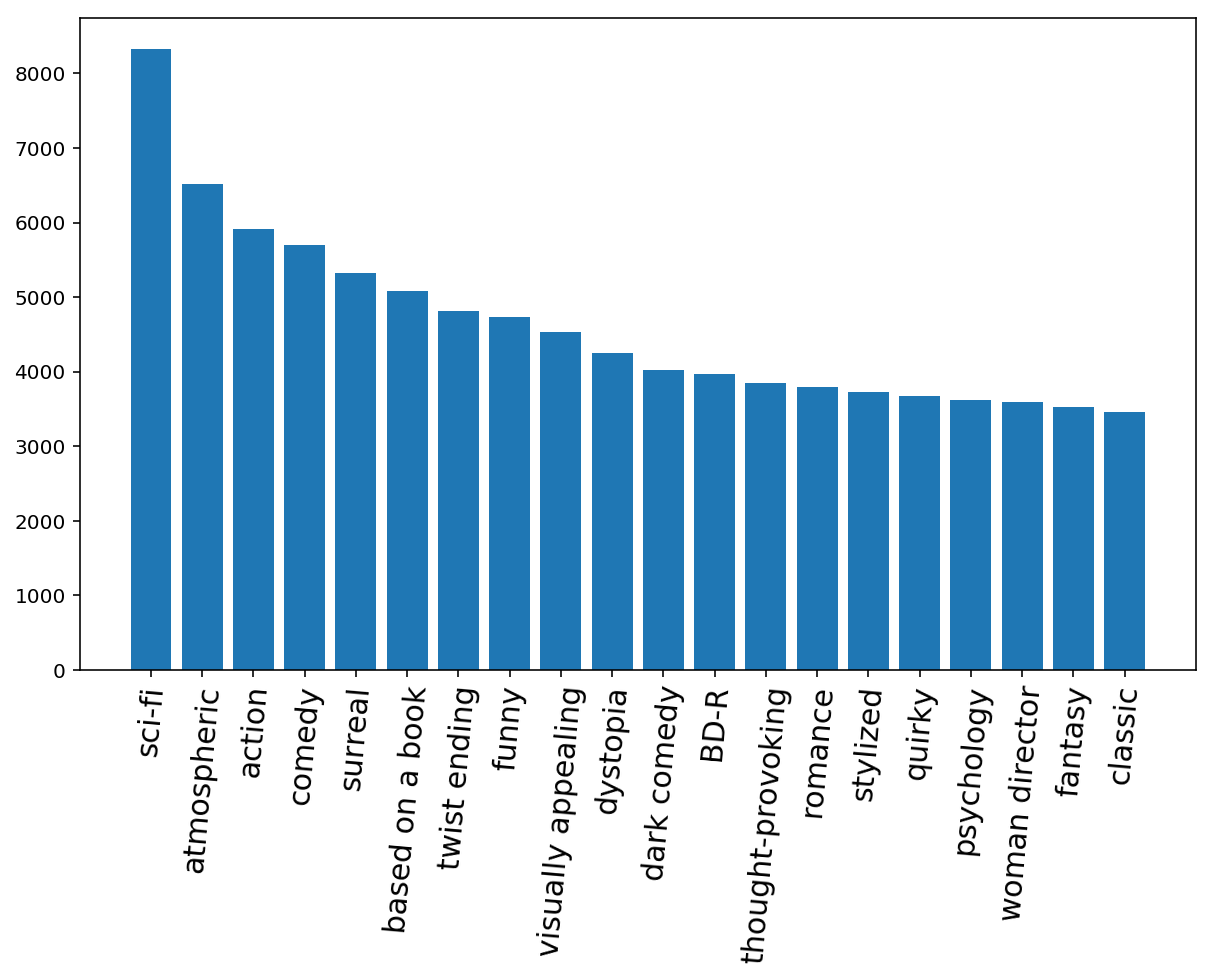

In [34]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [71]:
######################################
######### YOUR CODE HERE #############
######################################
top10_movies = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda joined: joined[1][0], ascending=False) \
    .map(lambda r: (r[1][1][1], r[1][0])) \
    .take(10)

In [72]:
top10_movies

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [82]:
%%time
######################################
######### YOUR CODE HERE #############
######################################

# maybe filter first will be faster
top10_5movies = ratings \
    .map(lambda r: (r.movie_id, int(r.rating == 5.0))) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .sortBy(lambda joined: joined[1][0], ascending=False) \
    .map(lambda r: (r[1][1][1], r[1][0])) \
    .take(10)

CPU times: user 34.6 ms, sys: 2.11 ms, total: 36.7 ms
Wall time: 22.9 s


In [83]:
top10_5movies

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

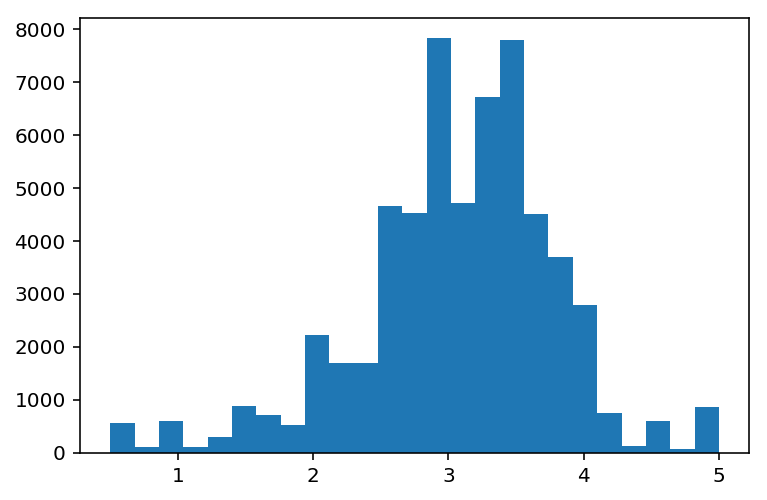

In [104]:
######################################
######### YOUR CODE HERE #############
######################################

avg_rating_count = movie_avg_rating.map(lambda m: m[1]).collect()
plt.hist(avg_rating_count, bins=25);

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

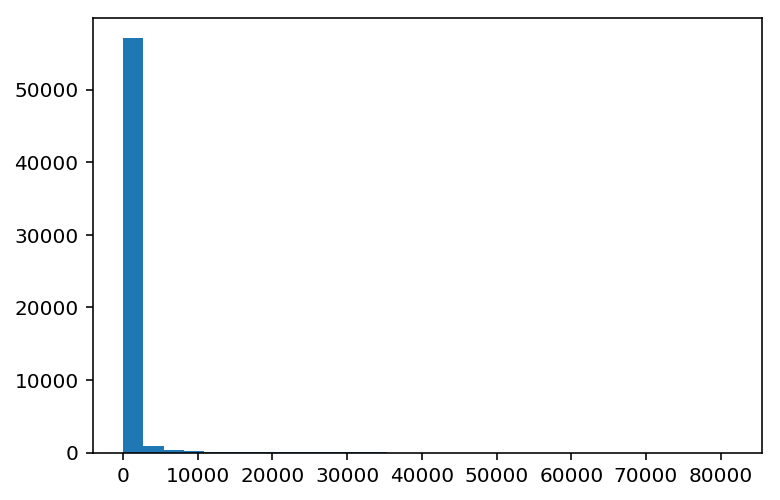

In [108]:
######################################
######### YOUR CODE HERE #############
######################################
movies_by_ratings = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda r: r[1]) \
    .collect()

plt.hist(movies_by_ratings, bins=30);

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [150]:
######################################
######### YOUR CODE HERE #############
######################################
movies_with_genres = sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(",")) \
    .filter(lambda arr: arr[0].isdigit()) \
    .flatMap(lambda s: [g for g in s[-1].split("|")]) \
    .map(lambda g: (g, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

In [155]:
movies_with_genres

[('Sci-Fi', 3595),
 ('Horror', 5989),
 ('Drama', 25606),
 ('Action', 7348),
 ('Western', 1399),
 ('Children', 2935),
 ('Musical', 1054),
 ('Documentary', 5605),
 ('Thriller', 8654),
 ('Fantasy', 2731),
 ('Romance', 7719),
 ('IMAX', 195),
 ('Comedy', 16870),
 ('(no genres listed)', 5062),
 ('Adventure', 4145),
 ('Crime', 5319),
 ('War', 1874),
 ('Animation', 2929),
 ('Mystery', 2925),
 ('Film-Noir', 353)]

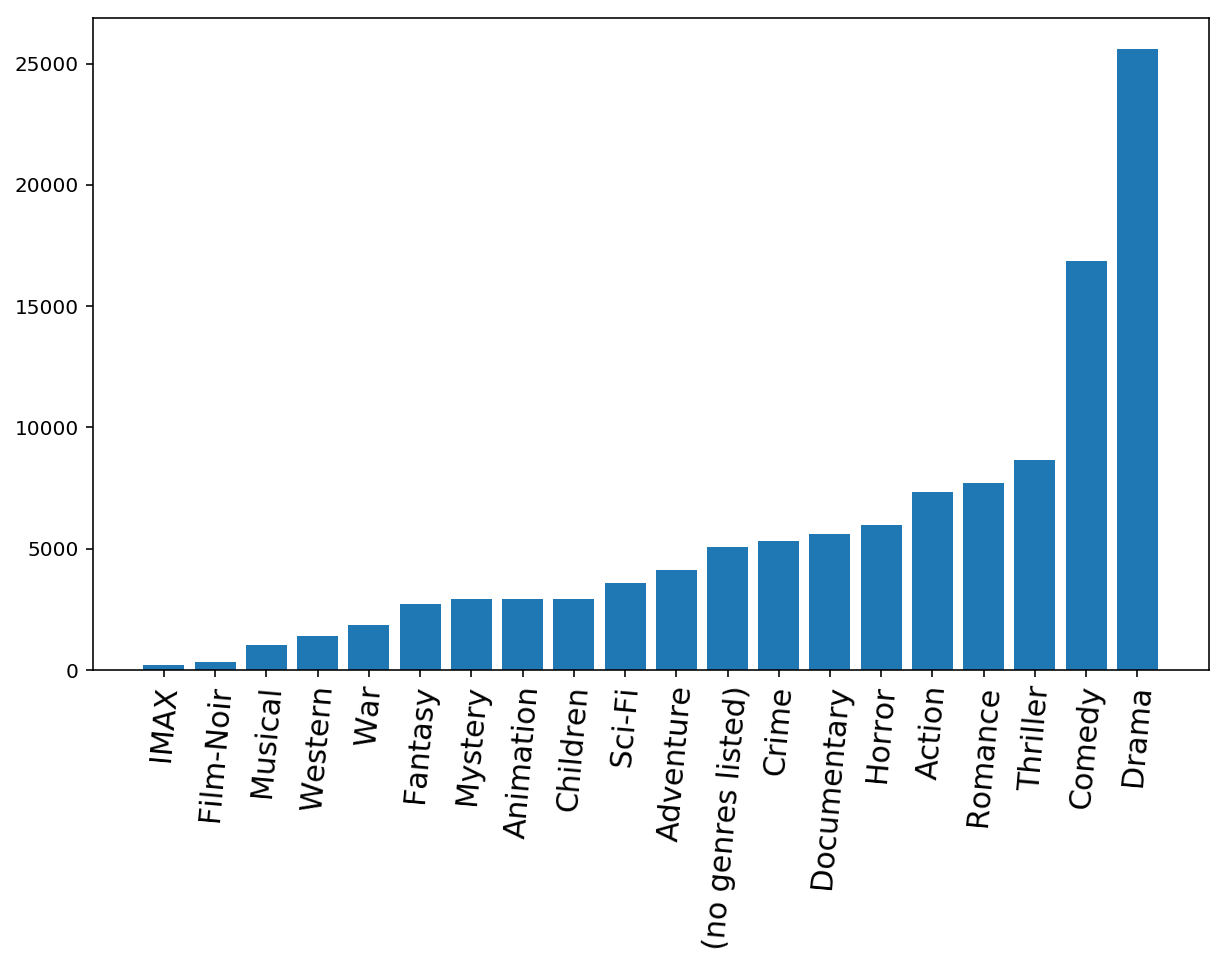

In [154]:
movies_with_genres_sorted = sorted(movies_with_genres, key=lambda key: key[1])

keys, values = zip(*movies_with_genres_sorted)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [277]:
######################################
######### YOUR CODE HERE #############
######################################
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

links = sc.textFile(LINKS_PATH)
tmdb = sqlContext.read.json(TMDB_PATH).rdd

In [278]:
links = links \
    .map(lambda s: (s.split(",")[2], s.split(",")[0])) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: arr[0])

### Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`

In [295]:
tmdb \
    .filter(lambda row: hasattr(row.casts, 'cast')) \
    .filter(lambda row: 31 in [p.id for p in row.casts.cast]) \
    .map(lambda row: str(row.id)) \
    .keyBy(lambda row: row) \
    .join(links) \
    .map(lambda row: row[1][1][1]) \
    .keyBy(lambda row: int(row)) \
    .join(movies) \
    .map(lambda row: row[1][1][1]) \
    .collect()

['Sleepless in Seattle (1993)',
 '"Celluloid Closet',
 'Elvis Has Left the Building (2004)',
 '"\'burbs',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 '"League of Their Own',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Punchline (1988)',
 'Turner & Hooch (1989)',
 '"Simpsons Movie',
 'Larry Crowne (2011)',
 'Toy Story Toons: Small Fry (2011)',
 '"Man with One Red Shoe',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 'Mazes and Monsters (1982)',
 'The Post (2017)',
 '"Money Pit',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'California Typewriter (2017)',
 'Radio Flyer (1992)',
 'Apollo 13 (1995)',
 '"Pixar Story',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 '"The Mayo Clinic',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 '"Ladykillers',
 '

### Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [305]:
tmdb \
    .filter(lambda row: hasattr(row.casts, 'cast')) \
    .flatMap(lambda row: [(p.id, p.name) for p in row.casts.cast]) \
    .map(lambda row: (row, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda row: row[1], ascending=False) \
    .map(lambda row: (row[0][1], row[1])) \
    .take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 130)]

In [368]:
tmdb \
    .filter(lambda row: hasattr(row.casts, 'cast')) \
    .flatMap(lambda row: [((p.id, p.name), 1) for p in row.casts.cast]) \
    .reduceByKey(lambda a, b: a + b) \
    .take(10)

[((34758, 'Joseph Cawthorn'), 21),
 ((1799267, 'Diana C. Skinner'), 1),
 ((1410329, 'Nikki Chapman'), 1),
 ((104211, 'Jean-Loup Philippe'), 1),
 ((1372535, 'Ryouko Ima'), 1),
 ((2083671, 'Manny La Carruba'), 1),
 ((1158351, 'Paige Lauren Billiot'), 3),
 ((1833014, 'Harry Johnson'), 1),
 ((2121149, 'Jonathan Mårtensson'), 1),
 ((55253, 'Michelle Krusiec'), 16)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [441]:
######################################
######### YOUR CODE HERE #############
######################################

unique_genres = tmdb \
    .filter(lambda row: row.genres) \
    .flatMap(lambda row: [g.name for g in row.genres]) \
    .distinct() \
    .collect()

In [442]:
unique_genres

['Science Fiction',
 'Comedy',
 'Mystery',
 'Action',
 'Western',
 'Adventure',
 'Documentary',
 'Romance',
 'Fantasy',
 'Animation',
 'TV Movie',
 'Music',
 'Family',
 'Thriller',
 'Horror',
 'Crime',
 'Drama',
 'History',
 'War']

In [492]:
def calc_genre_ratio(genre_count, unique_genres):
    total = sum(map(lambda t: t[1], genre_count))
    
    ratios = {g:0 for g in unique_genres}
    
    for g, count in genre_count:
        ratios[g] = count / total
        
    return list(ratios.values())

In [508]:
import numpy as np

year_genre_count = tmdb \
    .filter(lambda row: row.genres) \
    .flatMap(lambda row: [((row.release_date[:4], g.name), 1) for g in row.genres if row.release_date[:4] != '']) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda row: (row[0][0], (row[0][1], row[1]))) \
    .groupByKey() \
    .mapValues(list) \
    .sortBy(lambda row: row[0]) \
    .mapValues(lambda value: calc_genre_ratio(value, unique_genres))

In [511]:
years = year_genre_count.map(lambda row: int(row[0])).collect()
genre_count = year_genre_count.map(lambda row: row[1]).collect()

# years = list(map(lambda tup: int(tup[0]), year_genre_count))
# genre_count = list(map(lambda tup: tup[1], year_genre_count))

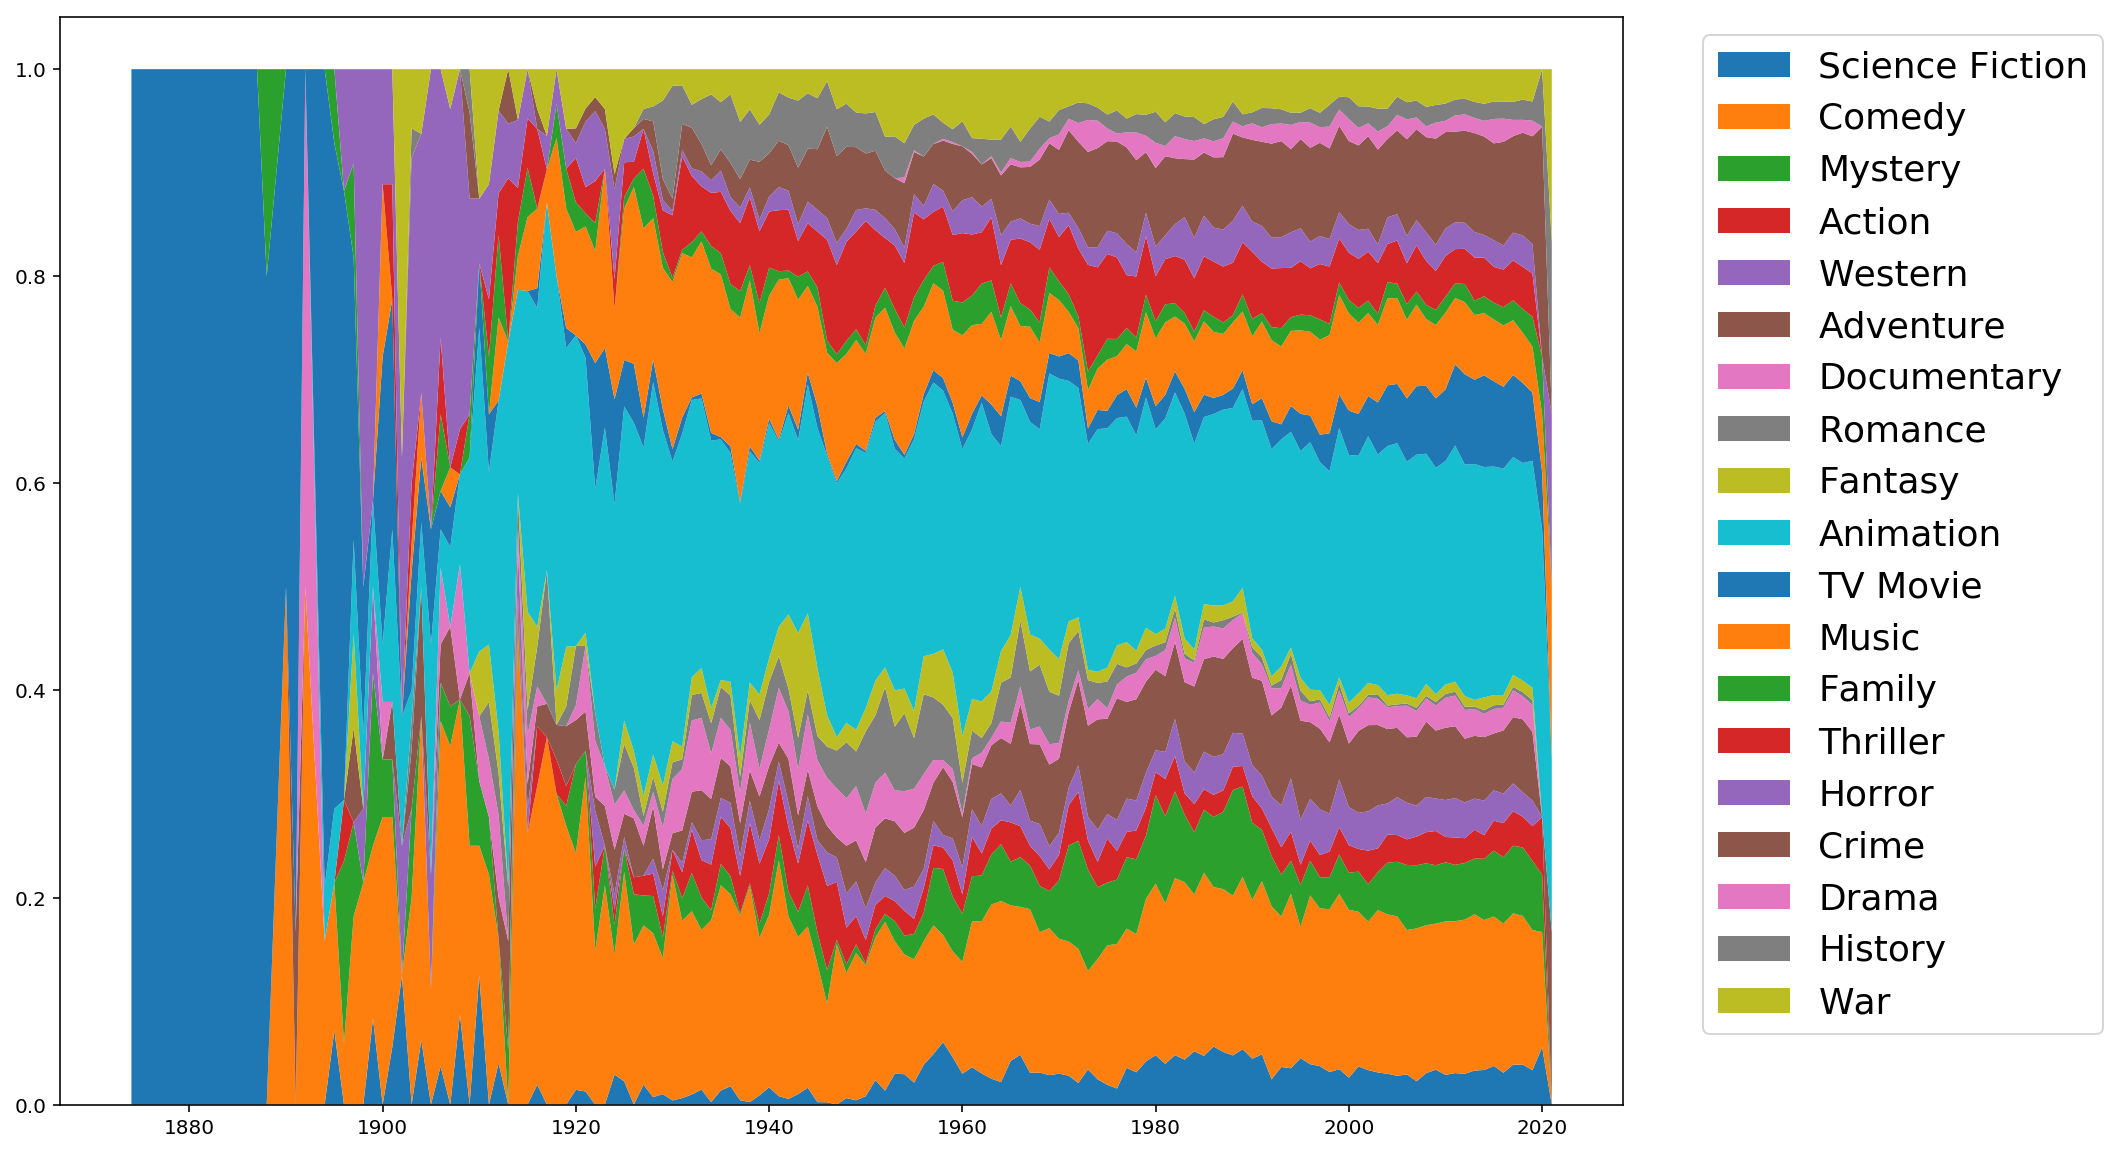

In [514]:
plt.figure(figsize=(14, 10))
plt.stackplot(years, np.vstack(genre_count).T, labels=unique_genres);
plt.legend(loc="upper left", bbox_to_anchor=(1.04, 1), fontsize=18);

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [308]:
######################################
######### YOUR CODE HERE #############
######################################
movies_with_genres = sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(",")) \
    .filter(lambda arr: arr[0].isdigit()) \
    .flatMap(lambda s: [(s[0], g) for g in s[-1].split("|")])

In [309]:
movies_with_genres.take(10)

[('1', 'Adventure'),
 ('1', 'Animation'),
 ('1', 'Children'),
 ('1', 'Comedy'),
 ('1', 'Fantasy'),
 ('2', 'Adventure'),
 ('2', 'Children'),
 ('2', 'Fantasy'),
 ('3', 'Comedy'),
 ('3', 'Romance')]